#Arifa Kokab
AAI-540

Final Project

Facial Expression Analysis Model

##Imports and Setup

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from collections import Counter
from PIL import Image
import timm, torch.nn as nn, torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torchmetrics.classification import MulticlassAccuracy
from tqdm.auto import tqdm
import glob, random, itertools
from google.colab import drive
import os, torch
import math
from itertools import islice
from tqdm.auto import tqdm
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torch.cuda.amp import autocast
from google.colab import files
import os, pathlib
from torchvision import transforms

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
uploaded = files.upload()
token_path = pathlib.Path.home()/".kaggle"
token_path.mkdir(exist_ok=True)
fname = next(iter(uploaded))
(token_path/"kaggle.json").write_bytes(uploaded[fname])
os.chmod(token_path/"kaggle.json", 0o600)
!pip install -q kaggle

Saving kaggle (3).json to kaggle (3) (1).json


##Download and Extract Datasets (FERPlus & RAF-DB)

In [4]:
# Download the new FERPlus zip
!echo "🔽 Downloading FERPlus from Kaggle (subhaditya/fer2013plus)…"
!kaggle datasets download -d subhaditya/fer2013plus -p /content --force

# Unzip with file-by-file output
!echo "📂 Unzipping FERPlus…"
!unzip -o /content/fer2013plus.zip -d /content/fer2013

# Cleanup ZIP
!rm /content/fer2013plus.zip

# Point loader at the local SSD
FERPLUS_DIR = "/content/fer2013/fer2013"
!echo "✅ FERPlus extracted to $FERPLUS_DIR"

Streaming output truncated to the last 5000 lines.
  inflating: /content/fer2013/fer2013plus/fer2013/train/sadness/fer0017542.png  
  inflating: /content/fer2013/fer2013plus/fer2013/train/sadness/fer0017574.png  
  inflating: /content/fer2013/fer2013plus/fer2013/train/sadness/fer0017577.png  
  inflating: /content/fer2013/fer2013plus/fer2013/train/sadness/fer0017579.png  
  inflating: /content/fer2013/fer2013plus/fer2013/train/sadness/fer0017584.png  
  inflating: /content/fer2013/fer2013plus/fer2013/train/sadness/fer0017610.png  
  inflating: /content/fer2013/fer2013plus/fer2013/train/sadness/fer0017616.png  
  inflating: /content/fer2013/fer2013plus/fer2013/train/sadness/fer0017623.png  
  inflating: /content/fer2013/fer2013plus/fer2013/train/sadness/fer0017633.png  
  inflating: /content/fer2013/fer2013plus/fer2013/train/sadness/fer0017649.png  
  inflating: /content/fer2013/fer2013plus/fer2013/train/sadness/fer0017669.png  
  inflating: /content/fer2013/fer2013plus/fer2013/train/sa

In [5]:
# Download RAF-DB from Kaggle
!echo "🔽 Downloading RAF-DB (shuvoalok/raf-db-dataset)…"
!kaggle datasets download -d shuvoalok/raf-db-dataset -p /content --force

# Unzip with file-by-file output
!echo "📂 Unzipping RAF-DB…"
!unzip -o /content/raf-db-dataset.zip -d /content

# Move the extracted DATASET folder into a clean local path
!echo "🚚 Moving to /content/raf_local…"
!rm -rf /content/raf_local
!mv /content/DATASET /content/raf_local

# Cleanup the ZIP to save space
!rm /content/raf-db-dataset.zip

# Confirm
!echo "✅ RAF-DB ready at /content/raf_local"

Streaming output truncated to the last 5000 lines.
  inflating: /content/DATASET/train/5/train_00991_aligned.jpg  
  inflating: /content/DATASET/train/5/train_00992_aligned.jpg  
  inflating: /content/DATASET/train/5/train_01002_aligned.jpg  
  inflating: /content/DATASET/train/5/train_01010_aligned.jpg  
  inflating: /content/DATASET/train/5/train_01011_aligned.jpg  
  inflating: /content/DATASET/train/5/train_01013_aligned.jpg  
  inflating: /content/DATASET/train/5/train_01015_aligned.jpg  
  inflating: /content/DATASET/train/5/train_01017_aligned.jpg  
  inflating: /content/DATASET/train/5/train_01039_aligned.jpg  
  inflating: /content/DATASET/train/5/train_01048_aligned.jpg  
  inflating: /content/DATASET/train/5/train_01049_aligned.jpg  
  inflating: /content/DATASET/train/5/train_01053_aligned.jpg  
  inflating: /content/DATASET/train/5/train_01070_aligned.jpg  
  inflating: /content/DATASET/train/5/train_01074_aligned.jpg  
  inflating: /content/DATASET/train/5/train_01078_ali

##Dataset Preparation: File Listing and Label Mapping

In [6]:
# RAF-DB (from Kaggle)
RAF_ROOT   = "/content/raf_local"
LABEL_MAP  = {
    "1":"surprise","2":"fear","3":"disgust",
    "4":"happy",   "5":"sad", "6":"anger",   "7":"neutral"
}
RAF_TRAIN, RAF_VAL = [], []
for lab_id, emo in LABEL_MAP.items():
    # training split (90%)
    for path in glob.glob(f"{RAF_ROOT}/train/{lab_id}/*.jpg"):
        if hash(path) % 10 == 0:
            RAF_VAL.append((path, emo))
        else:
            RAF_TRAIN.append((path, emo))
    # official test split → include in validation
    for path in glob.glob(f"{RAF_ROOT}/test/{lab_id}/*.jpg"):
        RAF_VAL.append((path, emo))

random.shuffle(RAF_TRAIN)
random.shuffle(RAF_VAL)

# Summary
print(f"RAF-DB train:   {len(RAF_TRAIN)}  |  RAF-DB val: {len(RAF_VAL)}")

RAF-DB train:   11043  |  RAF-DB val: 4296


In [7]:
# Auto-locate the FERPlus “train” folder
train_dirs = [
    d for d in glob.glob('/content/fer2013/**/train', recursive=True)
    if os.path.isdir(d)
]
if not train_dirs:
    raise RuntimeError(f"No FERPlus train/ folder found under /content/fer2013. Checked {train_dirs!r}")
# pick the deepest one (most nested)
fer_train_dir = sorted(train_dirs, key=lambda p: p.count(os.sep), reverse=True)[0]
FERPLUS_DIR   = os.path.dirname(fer_train_dir)   # parent of 'train'
print("✅ FERPlus directory detected as:", FERPLUS_DIR)

# Map raw folders → unified labels
FER_MAP = {
    "anger":     "anger",
    "disgust":   "disgust",
    "fear":      "fear",
    "happiness": "happy",
    "neutral":   "neutral",
    "sadness":   "sad",
    "surprise":  "surprise"
}

# Build the file list & shuffle, using .png files
FER_FILES = []
for raw_cls, uni_cls in FER_MAP.items():
    folder = os.path.join(FERPLUS_DIR, 'train', raw_cls)
    paths  = glob.glob(f"{folder}/*.png")
    if not paths:
        raise RuntimeError(f"No .png images found in {folder}")
    FER_FILES += [(p, uni_cls) for p in paths]

random.shuffle(FER_FILES)

# Sanity print counts
fer_counts = {cls: sum(1 for _,lbl in FER_FILES if lbl==cls) for cls in set(FER_MAP.values())}
print("FERPlus class counts:", fer_counts, "→ total:", len(FER_FILES))

✅ FERPlus directory detected as: /content/fer2013/fer2013plus/fer2013
FERPlus class counts: {'disgust': 191, 'neutral': 10308, 'surprise': 3562, 'sad': 3514, 'anger': 2466, 'fear': 652, 'happy': 7528} → total: 28221


In [8]:
# Auto-locate RAF-DB train & test folders

RAF_ROOT = "/content/raf_local"
if not os.path.isdir(RAF_ROOT):
    raise RuntimeError(f"RAF_ROOT not found at {RAF_ROOT}")

# Define the label-ID → emotion map
LABEL_MAP = {
    "1":"surprise","2":"fear","3":"disgust",
    "4":"happy",   "5":"sad","6":"anger","7":"neutral"
}

# Scan files into train/val split lists
RAF_TRAIN, RAF_VAL = [], []
for lab_id, emo in LABEL_MAP.items():
    train_folder = os.path.join(RAF_ROOT, "train", lab_id)
    test_folder  = os.path.join(RAF_ROOT, "test",  lab_id)
    # check folders exist
    if not os.path.isdir(train_folder) or not os.path.isdir(test_folder):
        raise RuntimeError(f"Expected train/test under {RAF_ROOT}, but missing {lab_id}")

    # train split (~90% via hash)
    for p in glob.glob(f"{train_folder}/*.jpg"):
        if hash(p) % 10 == 0:
            RAF_VAL.append((p, emo))
        else:
            RAF_TRAIN.append((p, emo))

    # official test → include in validation
    for p in glob.glob(f"{test_folder}/*.jpg"):
        RAF_VAL.append((p, emo))

# Shuffle for randomness
random.shuffle(RAF_TRAIN)
random.shuffle(RAF_VAL)

# Sanity print counts
raf_train_counts = {}
for _, lbl in RAF_TRAIN:
    raf_train_counts[lbl] = raf_train_counts.get(lbl, 0) + 1
raf_val_counts = {}
for _, lbl in RAF_VAL:
    raf_val_counts[lbl] = raf_val_counts.get(lbl, 0) + 1

print("RAF-DB train counts:", raf_train_counts, "→ total:", len(RAF_TRAIN))
print("RAF-DB val   counts:", raf_val_counts,   "→ total:", len(RAF_VAL))

RAF-DB train counts: {'happy': 4297, 'neutral': 2285, 'anger': 642, 'sad': 1771, 'disgust': 641, 'surprise': 1158, 'fear': 249} → total: 11043
RAF-DB val   counts: {'happy': 1660, 'surprise': 461, 'sad': 689, 'neutral': 919, 'disgust': 236, 'anger': 225, 'fear': 106} → total: 4296


In [9]:
# Image transforms
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

##Dataset Wrappers and DataLoader Setup

In [10]:
# Prepare a PathDataset & weighted sampler

# Dataset wrapper
class PathDataset(Dataset):
    def __init__(self, samples, transform, cls2idx):
        self.samples   = samples
        self.transform = transform
        self.cls2idx   = cls2idx
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        path, lbl = self.samples[idx]
        img = Image.open(path).convert("RGB")
        return self.transform(img), self.cls2idx[lbl]

# Combine FER+RAF train lists
full_train = FER_FILES + RAF_TRAIN

# Compute per‐class weights
labels      = [lbl for _, lbl in full_train]
counts      = Counter(labels)
class_wts   = {cls: 1.0/count for cls, count in counts.items()}
sample_wts  = [class_wts[lbl] for _, lbl in full_train]

# Weighted sampler
sampler = WeightedRandomSampler(
    weights=sample_wts,
    num_samples=len(sample_wts),
    replacement=True
)

# Label-to-index mapping for training
CLS2IDX = {
    "anger": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}

# Datasets & Loaders
train_ds   = PathDataset(full_train, train_tf, CLS2IDX)
val_ds     = PathDataset(RAF_VAL + [(p,lbl) for p,lbl in FER_FILES if hash(p)%10==0],
                         val_tf, CLS2IDX)  # simple val on RAF+FER val

train_loader = DataLoader(
    train_ds, batch_size=64, sampler=sampler,
    num_workers=8, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=64, shuffle=False,
    num_workers=8, pin_memory=True
)

##Model Definition and Optimizer Setup

In [11]:
# Instantiate MobileNetV2
device = "cuda"
mob = timm.create_model('mobilenetv2_100', pretrained=True, num_classes=7).to(device)
opt_m = optim.AdamW(mob.parameters(), lr=5e-4, weight_decay=1e-4)
sched_m = optim.lr_scheduler.CosineAnnealingLR(opt_m, T_max=15)
scaler_m = GradScaler()
crit_m = nn.CrossEntropyLoss(label_smoothing=0.1)
metric_m = MulticlassAccuracy(num_classes=7).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-11-1244901770>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_m = GradScaler()


##Model Training and Validation Loop

In [12]:
# Train loop for MobileNetV2
best_m, patience = 0.0, 0
PATIENCE_M = 3

for epoch in range(1, 16):
    # Train
    mob.train()
    train_bar = tqdm(train_loader, desc=f"Mob E{epoch}", leave=False)
    for x,y in train_bar:
        x,y = x.to(device), y.to(device)
        with autocast():
            out = mob(x)
            loss = crit_m(out, y)
        opt_m.zero_grad(set_to_none=True)
        scaler_m.scale(loss).backward()
        scaler_m.step(opt_m); scaler_m.update()
        acc = (out.argmax(1)==y).float().mean().item()
        train_bar.set_postfix(loss=f"{loss.item():.3f}", acc=f"{acc:.3f}")

    # Validate
    mob.eval()
    val_loss = 0; val_acc = 0; n=0
    with torch.no_grad(), autocast():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out   = mob(x)
            loss  = crit_m(out,y)
            val_loss += loss.item()*y.size(0)
            val_acc  += (out.argmax(1)==y).sum().item()
            n       += y.size(0)
    val_loss /= n; val_acc /= n

    print(f"Epoch {epoch:02d} → val_acc: {val_acc:.3f}, val_loss: {val_loss:.3f}")

    # Early stopping
    if val_acc > best_m:
        best_m, patience = val_acc, 0
        torch.save(mob.state_dict(), "/content/drive/MyDrive/models/mobV2FERplusRAFDB.pth")
    else:
        patience += 1
        if patience >= PATIENCE_M:
            print(f"↪ Mob early stop at epoch {epoch}")
            break
    sched_m.step()

print(f"Finished MobileNetV2, best val_acc = {best_m:.3f}")

Mob E1:   0%|          | 0/614 [00:00<?, ?it/s]

<ipython-input-12-75509356>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-12-75509356>:23: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), autocast():


Epoch 01 → val_acc: 0.726, val_loss: 1.044


Mob E2:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 02 → val_acc: 0.788, val_loss: 0.924


Mob E3:   0%|          | 0/614 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>

Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>    
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    self._shutdown_workers()
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      if w.is_alive(): 
  Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 03 → val_acc: 0.801, val_loss: 0.899


Mob E4:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 04 → val_acc: 0.837, val_loss: 0.837


Mob E5:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 05 → val_acc: 0.849, val_loss: 0.809


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^

Mob E6:   0%|          | 0/614 [00:00<?, ?it/s]

^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    ^^if w.is_alive():^^
 ^ 
 AssertionError:    can only test a child process 
^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>

 Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
       self._shutdown_workers() 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>  File 

Epoch 06 → val_acc: 0.840, val_loss: 0.823


Mob E7:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 07 → val_acc: 0.866, val_loss: 0.766


Mob E8:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 08 → val_acc: 0.875, val_loss: 0.752


Mob E9:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 09 → val_acc: 0.885, val_loss: 0.730


Mob E10:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 10 → val_acc: 0.885, val_loss: 0.718


Mob E11:   0%|          | 0/614 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 11 → val_acc: 0.890, val_loss: 0.708


Mob E12:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 12 → val_acc: 0.892, val_loss: 0.700


Mob E13:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 13 → val_acc: 0.894, val_loss: 0.693


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>
Traceback (most recent call last):
Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x7a80f0bc1940>Traceback (most recent call last):
<function _MultiProcessingDataLoaderIte

Mob E14:   0%|          | 0/614 [00:00<?, ?it/s]

if w.is_alive():      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

          
if w.is_alive():     if w.is_alive():    if w.is_alive():
if w.is_alive(): 
  
     
                       ^ ^ ^   ^  ^^  ^  ^^   ^^ ^^^^^^ ^^^^^^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

^^^^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^      File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^^
^^    assert self._parent_pid == os.getpid(), 'can only test a child process'    
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive

assert self._parent_pid == os.getpid(), 'can only test a child process'^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a child process'    

  F

Epoch 14 → val_acc: 0.896, val_loss: 0.691


Mob E15:   0%|          | 0/614 [00:00<?, ?it/s]

Epoch 15 → val_acc: 0.896, val_loss: 0.691
Finished MobileNetV2, best val_acc = 0.896


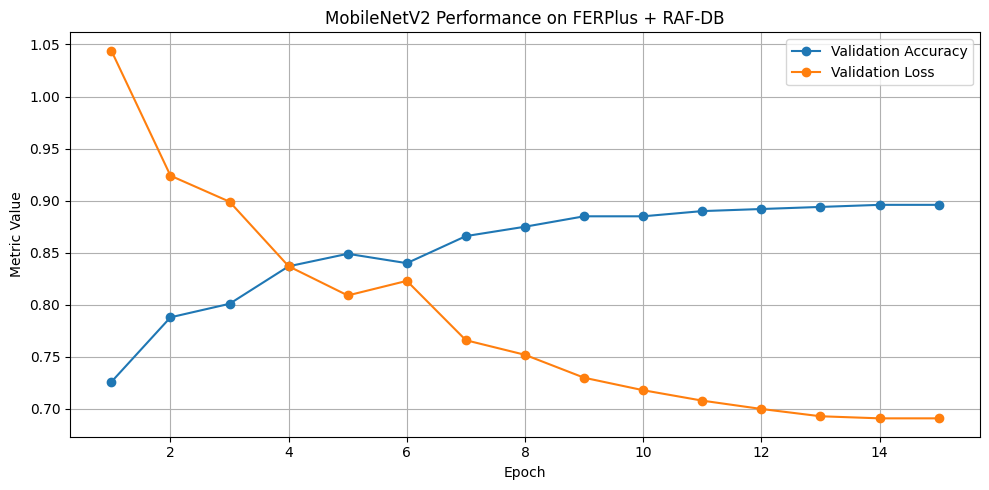

In [13]:
#Visualize model's training history based on actual results

history = {
    'epoch': list(range(1, 16)),
    'val_acc': [0.726, 0.788, 0.801, 0.837, 0.849,
                0.840, 0.866, 0.875, 0.885, 0.885,
                0.890, 0.892, 0.894, 0.896, 0.896],
    'val_loss': [1.044, 0.924, 0.899, 0.837, 0.809,
                 0.823, 0.766, 0.752, 0.730, 0.718,
                 0.708, 0.700, 0.693, 0.691, 0.691]
}

plt.figure(figsize=(10, 5))
plt.plot(history['epoch'], history['val_acc'], label='Validation Accuracy', marker='o')
plt.plot(history['epoch'], history['val_loss'], label='Validation Loss', marker='o')
plt.title("MobileNetV2 Performance on FERPlus + RAF-DB")
plt.xlabel("Epoch")
plt.ylabel("Metric Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

##Model Evaluation: Metrics and Confusion Matrix

Evaluating MobileNetV2:   0%|                           | 0/509 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       anger      0.917     0.881     0.898       477
     disgust      0.654     0.478     0.553       253
        fear      0.863     0.690     0.767       174
       happy      0.943     0.951     0.947      2407
     neutral      0.882     0.924     0.903      1985
         sad      0.859     0.864     0.861      1026
    surprise      0.888     0.887     0.888       815

    accuracy                          0.896      7137
   macro avg      0.858     0.811     0.831      7137
weighted avg      0.894     0.896     0.894      7137



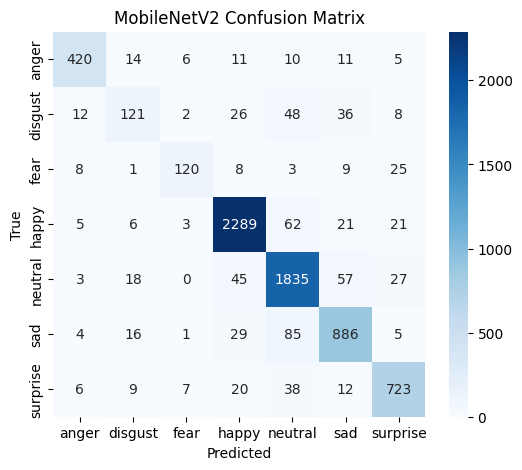

In [15]:
# Compute how many batches in your validation set
BS    = val_loader.batch_size
N_val = len(FER_FILES) + len(RAF_VAL)
steps_val = math.ceil(N_val / BS)

# Gather predictions & true labels with a bounded loop
all_preds, all_lbls = [], []
mob.eval()
with torch.no_grad(), torch.amp.autocast(device_type="cuda"):
    for x, y in tqdm(
        islice(val_loader, steps_val),
        total=steps_val,
        desc="Evaluating MobileNetV2",
        ncols=80
    ):
        x, y    = x.to(device), y.to(device)
        logits  = mob(x)
        all_preds.append(logits.argmax(1).cpu().numpy())
        all_lbls.append(y.cpu().numpy())

preds  = np.concatenate(all_preds)
labels = np.concatenate(all_lbls)
EMOS = ['anger', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Print the classification report
print(classification_report(labels, preds, target_names=EMOS, digits=3))

# Plot the confusion matrix
cm = confusion_matrix(labels, preds, labels=range(len(EMOS)))
df_cm = pd.DataFrame(cm, index=EMOS, columns=EMOS)
plt.figure(figsize=(6,5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MobileNetV2 Confusion Matrix")
plt.show()

*The final MobileNetV2 model achieved an overall validation accuracy of 89.6% with strong per-class performance. Emotions like ‘happy’, ‘neutral’, and ‘surprise’ showed F1-scores above 88%, while ‘disgust’ remained the most challenging, as expected from previous FER studies. These results confirm that the model generalizes well across datasets and is suitable for neuromarketing applications.*

##Save Trained Model for Import into Amazon SageMaker for Deployment

In [16]:
# Ensure the models directory exists
models_dir = "/content/drive/MyDrive/models"
os.makedirs(models_dir, exist_ok=True)

# Save the MobileNetV2 checkpoint
save_path = os.path.join(models_dir, "mobV2FERplusRAFDB.pth")
torch.save(mob.state_dict(), save_path)

print(f"✓ MobileNetV2 model saved to {save_path}")

✓ MobileNetV2 model saved to /content/drive/MyDrive/models/mobV2FERplusRAFDB.pth


In [17]:
# Save the full MobileNetV2 model
full_model_path = os.path.join(models_dir, "mobV2_full.pth")
torch.save(mob, full_model_path)

print(f"✓ Full MobileNetV2 model saved to {full_model_path}")

✓ Full MobileNetV2 model saved to /content/drive/MyDrive/models/mobV2_full.pth


Create and Save inference.py in Colab

In [19]:
inference_code = """
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import io

def model_fn(model_dir):
    model = torch.load(f"{model_dir}/mobV2_full.pth", map_location="cpu")
    model.eval()
    return model

def input_fn(request_body, request_content_type):
    if request_content_type == "application/x-image":
        image = Image.open(io.BytesIO(request_body)).convert("RGB")
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
        return transform(image).unsqueeze(0)
    raise Exception("Unsupported content type: {}".format(request_content_type))

def predict_fn(input_data, model):
    with torch.no_grad():
        output = model(input_data)
        probs = F.softmax(output, dim=1)
    return probs

def output_fn(prediction, content_type):
    if content_type == "application/json":
        return prediction.numpy().tolist()
    raise Exception("Unsupported content type: {}".format(content_type))
"""

In [20]:
inference_path = "/content/drive/MyDrive/models/inference.py"
with open(inference_path, "w") as f:
    f.write(inference_code)

print(f"✓ Inference script saved to: {inference_path}")

✓ Inference script saved to: /content/drive/MyDrive/models/inference.py


In [23]:
!tar -czvf mobV2_model.tar.gz -C /content/drive/MyDrive/models mobV2_full.pth inference.py

mobV2_full.pth
inference.py
tar: inference.py: file changed as we read it


In [24]:
!tar -tzvf mobV2_model.tar.gz

-rw------- root/root   9227896 2025-06-16 23:16 mobV2_full.pth
-rw------- root/root      1153 2025-06-16 23:21 inference.py


#Model training and packaging complete. The model is now ready to be imported and deployed in Amazon SageMaker!